In [1]:
import pandas as pd 
import numpy as np
import scripts.utils as utils

import os
import pickle

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Load Validation Data

In [2]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")
validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

In [3]:
req_keys = utils.target_keys

In [4]:
train_data = train_data[req_keys]
validation_data = validation_data[req_keys]

In [5]:
scaler = StandardScaler()
_ = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(validation_data)

valid_scaled = pd.DataFrame(valid_scaled, index = validation_data.index, columns = req_keys)
assert set(valid_scaled.index) == set(validation_data.index)

### Load MC Dropout Dictionaries

In [6]:
directory = "/share/rcifdata/jbarr/UKAEAGroupProject/"

In [7]:
list_dicts = []
for file in os.listdir(directory): 
    if file.endswith(".pkl"):
        dicts = pickle.load(open(directory+file, 'rb'))
        list_dicts.append(dicts)

/tmp/ipykernel_35516/3976890259.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


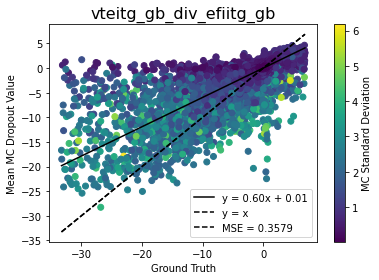

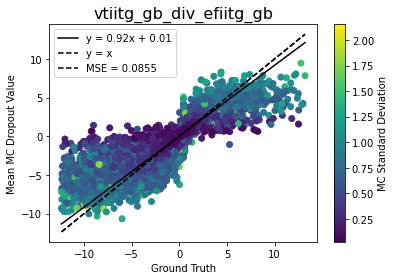

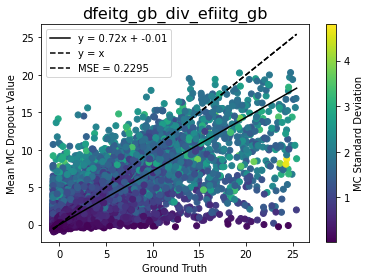

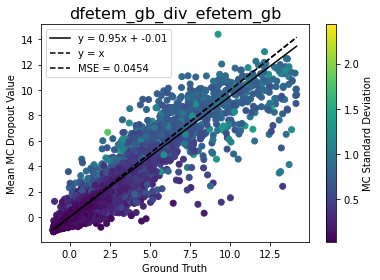

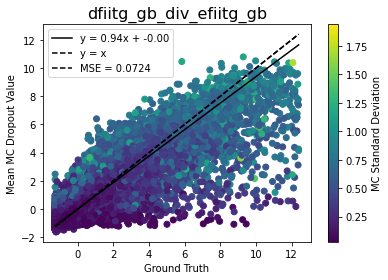

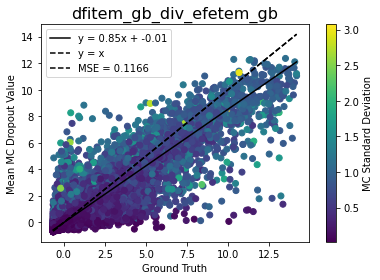

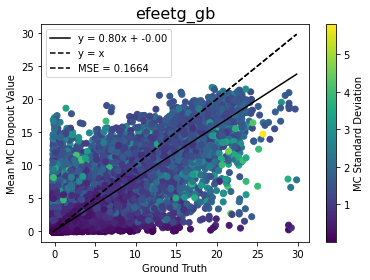

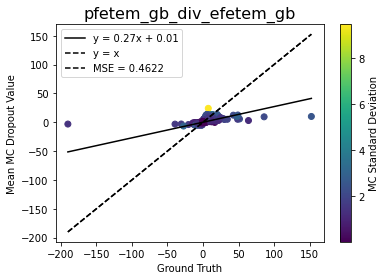

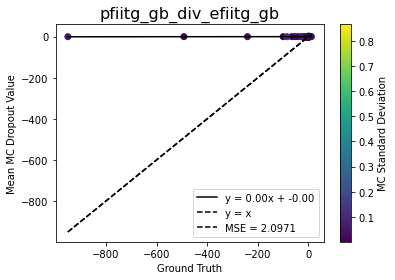

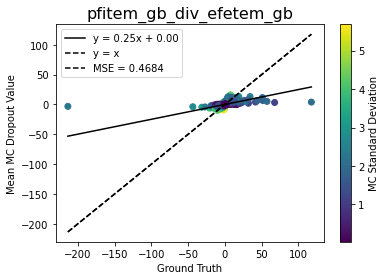

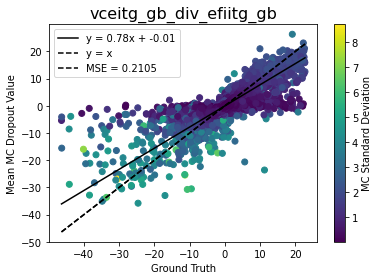

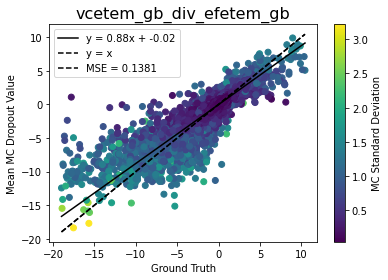

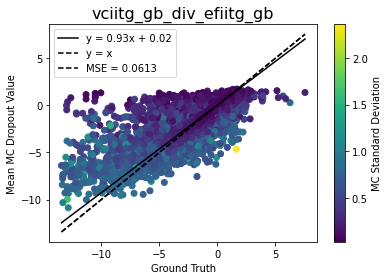

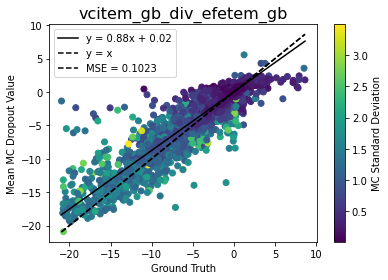

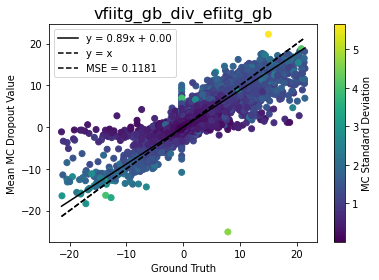

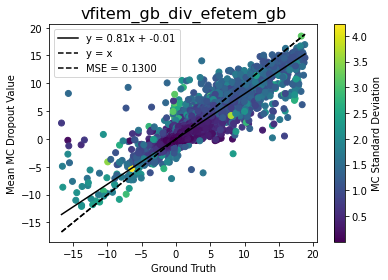

/home/tmadula/.conda/envs/UKAEA/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


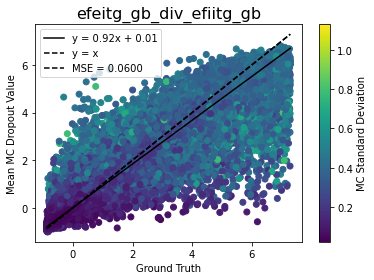

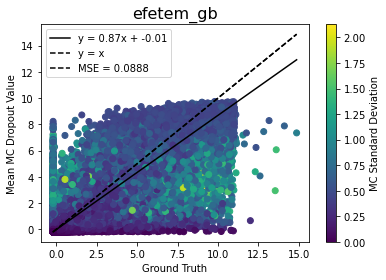

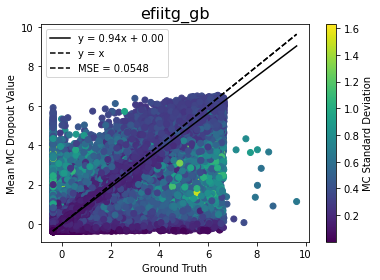

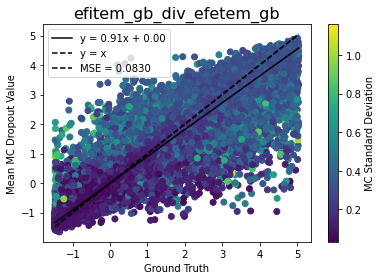

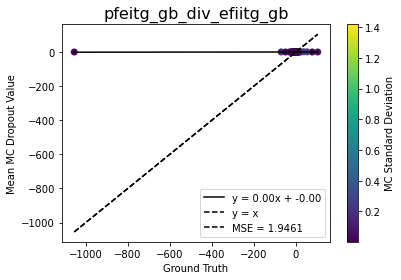

In [8]:
bad_vars = ['vritem_gb_div_efetem_gb','vriitg_gb_div_efiitg_gb' ]
for i in list_dicts: 
    for var in i:
        if var in bad_vars: 
            continue
        n_vals = i[var]['means'].shape[0]
        idx = i[var]['indices'][:n_vals]
#         print(f'n_mu: {m}, n_indx:{s}')
        
        ground_truth = valid_scaled[var].loc[i[var]['indices'][:n_vals]]
        
#         ground_truth = ground_truth[:10_000]
    
        mc_mean = i[var]['means']
        mc_std = i[var]['std']
        

        plt.figure()
        plt.scatter(ground_truth, mc_mean, c = mc_std)
        plt.colorbar(label = "MC Standard Deviation")
        plt.title(var, fontsize = 16)
        plt.xlabel('Ground Truth')
        plt.ylabel('Mean MC Dropout Value')
        
        min_x = np.min(ground_truth)
        max_x = np.max(ground_truth)
        
        if var not in bad_vars: 
        
            m, b = np.polyfit(ground_truth , mc_mean, 1)

            plt.plot(np.linspace(min_x,max_x,100), m*np.linspace(min_x,max_x,100)+b,
                     color = 'black',
                     label=f'y = {m:.2f}x + {b:.2f}');
        
        MSE = np.sum((ground_truth - mc_mean)**2)/ground_truth.shape[0]
        
        plt.plot(np.linspace(min_x,max_x,100), np.linspace(min_x,max_x,100),
                     color = 'black', label = 'y = x', ls = '--')
        
        plt.plot(np.linspace(min_x,max_x,100), np.linspace(min_x,max_x,100),
                     color = 'black', label = f'MSE = {MSE:.4f}', ls = '--')
        
        plt.legend()